# RadQG Demo
In this notebook, we will demonstrate the main functionalities of the RadQG project in a notebook environment. To work with the GUI application, please run the `app.py` file.

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import skimage.io as io
import sys

sys.path.append("..")
import radqg.configs as configs
from radqg.generator import Generator
from radqg.llm.openai import embed_fn as openai_embed_fn
from radqg.llm.openai import qa as openai_qa

### Extracting the figures and text from HTML files 

Please download your desired articles from the RadioGraphics website as HTML files and put them in the toy_data_dir folder. Do not change the names of the files and folders when saving them from the website. Five sample articles are already provided.

In [2]:
# Listing all the HTML files

toy_data_dir = configs.TOY_DATA_DIR

print("Name of the articles: \n")
for file in os.listdir(toy_data_dir):
    if file.endswith(".html"):
        print(file)

Name of the articles: 

Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics.html
Role of Multimodality Imaging in Gastroesophageal Reflux Disease and Its Complications, with Clinical and Pathologic Correlation _ RadioGraphics.html
Murphy’s Law_ What Can Go Wrong in the Gallbladder_ Resident and Fellow Education Feature _ RadioGraphics.html
Pearls and Pitfalls in Multimodality Imaging of Colonic Volvulus _ RadioGraphics.html
CT Findings of Acute Small-Bowel Entities _ RadioGraphics.html


### Create a QA generator

Creating the QA generator is the first step in the pipeline. In addition to the path to the directory containing the HTML files, we need to specify an embedding function (e.g., from OpenAI), and the chunk_size and chunk_overlap values that should be used for splitting the articles into chunks. The latter two could be changed in the notebook or in the `config.py` file.

The next step is to setup the generator. This step will return all the article names, paths to figures detected for the articles, their captions, and also a Python sampler for selecting random figures as the source for question generation. The user can specify a word or phrase as the interested `topic` when setting up the question bank for the generator. If provided, then the QA generator will be more inclined to select figures as the source for question genenration that have haptions related to the topic. Otherwise, the generator will pick completely random figures for question generation.

In [3]:
# Setting up the generator

generator = Generator(
    data_dir=toy_data_dir,
    embed_fn=openai_embed_fn,
    chunk_size=configs.CHUNK_SIZE,
    chunk_overlap=configs.CHUNK_OVERLAP,
)

topic = None
article_names, figpaths, captions, sampler = generator.setup_qbank(topic)

The collection "20231029_223027" has been created with:
    147 figures from 5 articles


### Figure selection
The next step is selecting a random figure. When the figure is selected, the name of the article containing the figure, the path to the figure, and the caption of the figure will be returned.

In [4]:
article_name, figpath, caption = generator.select_figure(
    article_names, figpaths, captions, sampler, reset_memory=False
)
print("Article name: ", article_name)
print("Figure path: ", figpath)
print("Caption: ", caption)

Article name:  Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics.html
Figure path:  /research/projects/m221279_Pouria/RadQG/data/html_articles/Internal Hernias in the Era of Multidetector CT_ Correlation of Imaging and Surgical Findings _ RadioGraphics_files/images_medium_rg.2016150113.fig18b.gif
Caption:  Figure 18b.Broad ligament hernia in a 58-year-old woman with a 1-day history of intermittent abdominal pain and vomiting and a history of three normal pregnancies.(a, b)Axial contrast-enhanced CT images obtained at different levels show a cluster of small bowel loops in the pouch of Douglas (arrowheads) and crowding mesenteric vessels (arrows). The uterus (*) is deviated inferiorly and to the right.(c)CoronalMPRCT image shows the hernia orifice (white arrows) below the tubal and ovarian branches (black arrow) of the left ovarian and uterine vessels. Enlargement of the distance between the uterus (*) and the left ovary (arrow

#### Generate a question

The final step is to generate the question. The user should specify a question/answering function (e.g., from OpenAI), the name of the article containing the figure, and the caption of the figure. The question/answering function will return a Python dictionary containing the question and an answer to the questio. Optionally, the generator could also return a subset of the article text (referred to as `context`) that was extracted from the article and the LLM used it for developing a better question from the figure.
> Note: The type_of_question could be one of ["MCQ", "Fill_in_the_Blanks", "Open-Ended", "Anki"].

Context: ...The portal venous and delayed phases were started automatically at 70 and 180 seconds, respectively, after the start of injection. Neither oral nor rectal contrast material was administered in any patients. Reconstructed axial images (section thickness of 5 mm, interval of 5 mm) and coronal MPR images (section thickness of 3 mm, interval of 3 mm) were obtained routinely. In some cases, thin-section axial images, additional MPR images, and 3D images were obtained. The most crucial condition in internal hernias is mechanical small bowel obstruction. Small bowel obstruction of the internal hernia is usually a closed-loop obstruction, in which a segment of the bowel is occluded at two adjacent points. A direct sign of a closed loop at CT is a U- or C-shaped, fluid-filled, distended intestinal loop, with radial distribution of stretched and thickened mesenteric vessels toward the point of the obstruction (23). An extremely helpful imaging sign of closed-loop intestine in an inte

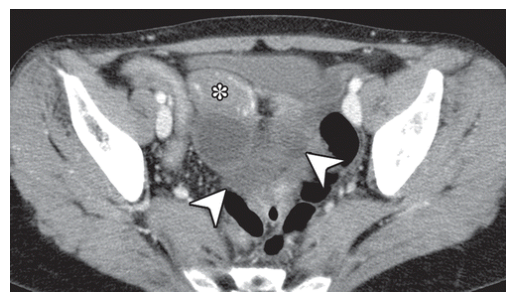

In [5]:
qa_dict, context = generator.generate_qa(
    qa_fn=openai_qa,
    article_name=article_name,
    caption=caption,
    type_of_question="Anki",
    return_context=True,
)

figure = io.imread(figpath).squeeze()
plt.imshow(figure)
plt.axis("off")
# print(f"Context: {context}") # Uncomment to see the context
print(f"Question: {qa_dict['question']}")
print(f"Answer: {qa_dict['answer']}")